In [10]:
# Step 1: Import Required Libraries

# Create Kaggle directory and copy the API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Download the dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
# Step 2: Set Up Data Generators with Augmentation

# Define data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale validation and test data without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    directory='/content/chest_xray/train',
    batch_size=32,
    target_size=(224, 224),  # Resize images to match pre-trained model input
    class_mode='binary',
    color_mode='rgb',  # Using RGB for transfer learning
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory='/content/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


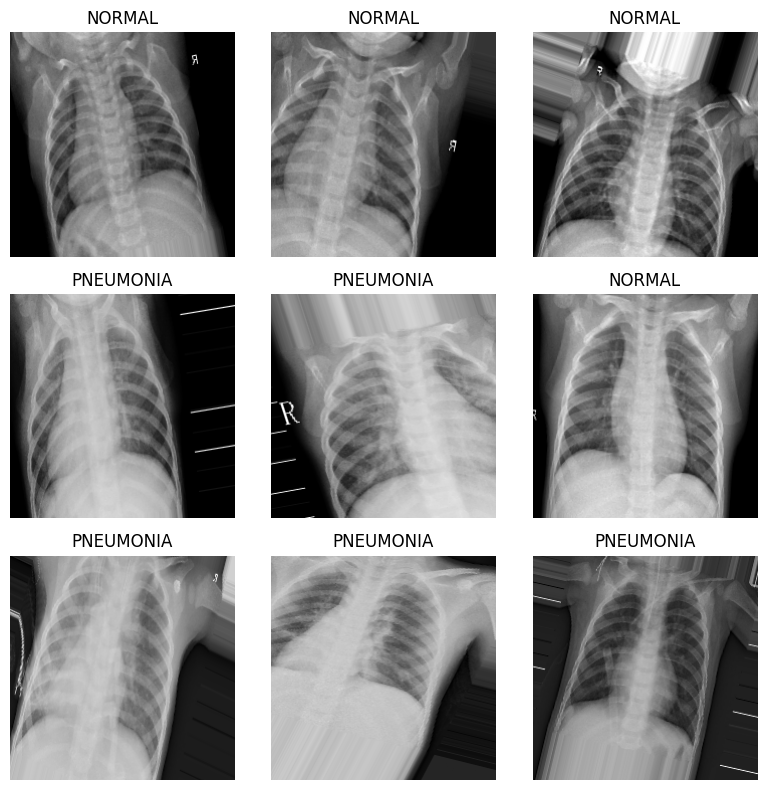

In [12]:
# Step 3: Visualize the Data

# Retrieve class names
class_names = list(train_generator.class_indices.keys())

# Plot a grid of 9 sample images from the training set
plt.figure(figsize=(8, 8))
images, labels = next(train_generator)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    plt.imshow(img)
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# Step 4: Calculate Class Weights

# Compute class weights to handle class imbalance
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Create a dictionary mapping class indices to weights
class_weight_dict = {i: class_weights_vals[i] for i in range(len(class_weights_vals))}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [14]:
# Step 5: Build the Transfer Learning Model

# Load the ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model to prevent training

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# Step 6: Set Up Callbacks

# Define Early Stopping to halt training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Save the best model based on validation loss
# Changed 'best_model.h5' to 'best_model.keras' to save the entire model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [9]:
# Step 8: Fine-Tune the Model (Optional)

# Unfreeze the last 50 layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training the model with fine-tuning
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7135 - loss: 0.5337
Epoch 1: val_loss did not improve from 0.69734
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 625ms/step - accuracy: 0.7139 - loss: 0.5331 - val_accuracy: 0.5000 - val_loss: 0.7123 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 2: val_loss did not improve from 0.69734
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7123 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.8608 - loss: 0.3104
Epoch 3: val_loss did not improve from 0.69734
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 602ms/step - accuracy: 0.8608 - loss: 0.3104 - val_accuracy: 0.5000 - val_loss: 1.1294 - learning_rate: 1.0000e-05
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 4: val_loss did not improve from 0.69734
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 

In [18]:
# Step 9: Evaluate the Model

# Load the best saved model
# Changed 'best_model.h5' to 'best_model.keras' to match the saved filename
model.load_weights('best_model.keras')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Generate predictions and create a classification report
y_true = test_generator.classes
# Removed 'steps' parameter to ensure all samples are predicted
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred, target_names=class_names))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.8550 - loss: 0.3622
Test Accuracy: 0.7845
Test Loss: 0.4805
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step
              precision    recall  f1-score   support

      NORMAL       0.66      0.90      0.76       234
   PNEUMONIA       0.92      0.72      0.81       390

    accuracy                           0.79       624
   macro avg       0.79      0.81      0.78       624
weighted avg       0.82      0.79      0.79       624



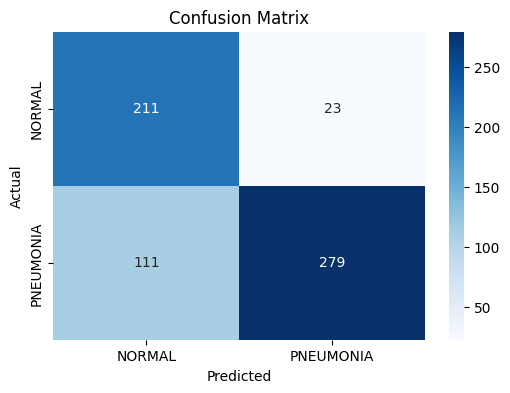

In [19]:
# Step 10: Confusion Matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


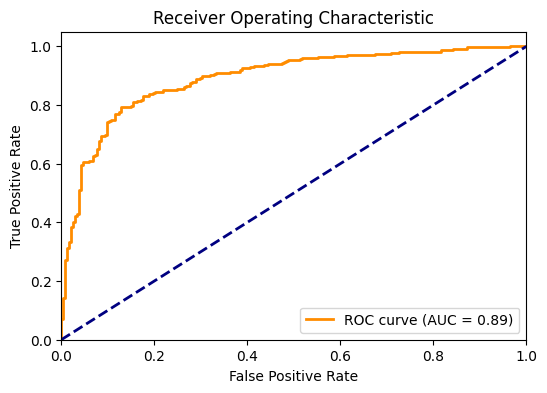

In [20]:
# Step 11: ROC Curve

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image (adjust the file path as needed)
img_path ='/content/normal.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224

# Preprocess the image: convert it to a numpy array and rescale pixel values
img_array = image.img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make the prediction
prediction_prob = model.predict(img_array)

# Interpret the result: 0 is 'NORMAL', 1 is 'PNEUMONIA'
if prediction_prob[0] > 0.5:
    print(f"Pneumonia detected with a probability of {prediction_prob[0][0]:.4f}") # Access the value within the array
else:
    print(f"Normal condition detected with a probability of {1 - prediction_prob[0][0]:.4f}") # Access the value within the array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Normal condition detected with a probability of 0.5172
